In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import random
import pandas as pd

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc):

    start = []
    
    ####  Spatial array
    x_r_train = 1*x_r
    y_t_train = 1*y_t
    N_x_train = int(x_r_train/x_r*N_x) 
    N_y_train = int(y_t_train/y_t*N_y) 
    
    x_train = np.linspace(x_l, x_r_train, N_x_train)  
    y_train = np.linspace(y_b, y_t, N_y)
    x_train = np.repeat(x_train, N_y)
    y_train = np.tile(y_train, N_x_train)
    
    n = x_train.shape[0]
    x_train = np.tile(x_train, N_t)
    y_train = np.tile(y_train, N_t)
    t_train = np.linspace(t_i, t_f, N_t)
    t_train = np.repeat(t_train, n )
    
    start.append( 0 )
    start.append( t_train.shape[0] ) 
    print('n = ', n)
    print('training data-size = ', t_train.shape[0] )
    
    # Boundary collocation points
    x_bc1 = np.ones((N_bc))*x_l
    y_bc1 = np.linspace(y_b, y_t, N_bc)
    t_bc1 = np.linspace(t_i+0.005,t_f,N_t)
    x_bc1 = np.tile(x_bc1, N_t)
    y_bc1 = np.tile(y_bc1, N_t)
    t_bc1 = np.repeat(t_bc1, N_bc)
    
    start.append( start[-1] + t_bc1.shape[0] )
    
    x_bc2 = np.ones((N_bc))*x_r
    y_bc2 = np.linspace(y_b+0.001,y_t,N_bc)
    t_bc2 = np.linspace(t_i+0.005,t_f,N_t)
    x_bc2 = np.tile(x_bc2, N_t)
    y_bc2 = np.tile(y_bc2, N_t)
    t_bc2 = np.repeat(t_bc2, N_bc)
    
    start.append( start[-1] + t_bc2.shape[0] )
    
    x_bc3 = np.linspace(x_l,x_r,N_bc)
    y_bc3 = np.ones((N_bc))*y_b
    t_bc3 = np.linspace(t_i+0.005,t_f,N_t)
    x_bc3 = np.tile(x_bc3, N_t)
    y_bc3 = np.tile(y_bc3, N_t)
    t_bc3 = np.repeat(t_bc3, N_bc)
    
    start.append( start[-1] + t_bc3.shape[0] )
    
    x_bc4 = np.linspace(x_l+0.001,x_r,N_bc)
    y_bc4 = np.ones((N_bc))*y_t
    t_bc4 = np.linspace(t_i+0.005,t_f,N_t)
    x_bc4 = np.tile(x_bc4, N_t)
    y_bc4 = np.tile(y_bc4, N_t)
    t_bc4 = np.repeat(t_bc4, N_bc)
    
    start.append( start[-1] + t_bc4.shape[0] )
    
    # np to torch
    
    x_T = np.concatenate((x_train, x_bc1, x_bc2, x_bc3, x_bc4), axis = 0)
    y_T = np.concatenate((y_train, y_bc1, y_bc2, y_bc3, y_bc4), axis = 0)
    t_T = np.concatenate((t_train, t_bc1, t_bc2, t_bc3, t_bc4), axis = 0)
    
    x_T = np_to_torch(x_T)
    y_T = np_to_torch(y_T)
    t_T = np_to_torch(t_T)
    
    return x_T, y_T, t_T, start, n

class RBF(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        y = 1.2*torch.exp(-5*torch.square(x)) - 0.1
        return y

class Sigm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        y = 1/( 1 + torch.exp(-80*x) )
        return y

def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        init.xavier_normal_(m.bias)
        # if m.bias is not None:
        #     init.constant_(m.bias, 0.01)
    
class ANN(nn.Module):
    def __init__(self, layer_size_1):
        super(ANN, self).__init__()

        rbf = RBF()
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()
        self.act = rbf
        mean_init = 0
        std_init = 0.707
        
        ########### Fully conected model-1 ###########
        
        modules_11 = []
        modules_11.append(nn.Linear(layer_size_1[0], layer_size_1[1]))  
        modules_11.append(self.act) 
        self.fc_11 = nn.Sequential( *modules_11 )

        # # for layer in [self.fc_11.modules()]:
        # #     if isinstance(layer, nn.Linear):
        # #         xavier_init(layer)
                
        modules_12 = []
        modules_12.append(nn.Linear(layer_size_1[1], layer_size_1[2])) 
        modules_12.append(self.act)
        self.fc_12 = nn.Sequential( *modules_12 )
        
        modules_13 = []
        modules_13.append(nn.Linear(layer_size_1[2], layer_size_1[3])) 
        self.fc_13 = nn.Sequential( *modules_13 )

        for layer in [self.fc_11.modules(), self.fc_12.modules(), self.fc_13.modules()]:
            if isinstance(layer, nn.Linear):
                xavier_init(layer)

    def forward(self, x_T, y_T, t_T, start, result, pr):

        ########### Fully conected model-1 ###########
        out_1 = self.fc_11( torch.cat((x_T, y_T, t_T),1) )
        out_2 = self.fc_12( out_1 )
        T = self.fc_13( out_1 + out_2 )
                      
        # T = self.fc_11( torch.cat((x_T, y_T, t_T),1) )
        dTdx = torch.autograd.grad(T, x_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_T, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        dTdy = torch.autograd.grad(T, y_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdy2 = torch.autograd.grad(dTdy, y_T, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
        dTdt = torch.autograd.grad(T, t_T, grad_outputs=torch.ones_like(T), create_graph=True)[0]

        ### matrix for interface boundary condition ###
        # m1 = torch.where(T >= 0.2, 1, 0)
        # Ns1 = torch.sum(m1) + 1
        m1 = 1
        Ns1 = 1
        
        m2 = 1 - m1
        Ns2 = 1

        return  T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, m1, Ns1, m2, Ns2
    
def get_loss(x_T, y_T, t_T, start, k1, k2, w1, w2, w3, w4, w5, w6, w7, q_norm, n, T_change, N_t):
 
    T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, m1, Ns1, m2, Ns2 = model( x_T, y_T, t_T, start, 0, 0)

    sigm = Sigm()
    tanh = nn.Tanh()
    
    # eq1 = w1*( torch.sum( torch.mul( torch.square( dTdt - k1*(d2Tdx2 + d2Tdy2)), sigm(T - T_change) ) ) 
    # + torch.sum( torch.mul( torch.square( dTdt - k2*(d2Tdx2 + d2Tdy2)), sigm(T_change - T) ) ) )/(n*N_t)

    eq1 = w1*( torch.sum( torch.mul( torch.square( dTdt - k1*(d2Tdx2 + d2Tdy2)), torch.where(T>=T_change,1,0) ) ) 
    + torch.sum( torch.mul( torch.square( dTdt - k2*(d2Tdx2 + d2Tdy2)), torch.where(T<T_change,1,0) ) ) )/(n*N_t)

    bc1 = w2*torch.sum( torch.square( dTdx[ start[1]:start[2] ] + q_norm ) )/(start[2]-start[1]) #left boundary
    bc2 = w3*torch.sum( torch.square( dTdy[ start[3]:start[4] ]  ) )/(start[4]-start[3]) #bottom boundary
    bc3 = w4*torch.sum( torch.square( dTdy[ start[4]:start[5] ] ) )/(start[5]-start[4]) #top boundary
    bc4 = w5*torch.sum( torch.square( dTdx[ start[2]:start[3] ] ) )/(start[3]-start[2]) #right boundary

    ic1 = w6*torch.sum( torch.square( T[0:n] )  )/(n) 
    # p = w7*torch.mean( torch.square(tanh(50*T) - 1))
    
    loss = eq1 + bc1 + bc2 + bc3 + ic1 +bc4
    
    return loss, eq1, bc1, bc2, bc3, ic1

def print_loss(epoch, loss, eq1, bc1, bc2, bc3, ic1):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())
    print('bc3_loss = ',bc3.detach().numpy())
    print('ic1_loss = ',ic1.detach().numpy())

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

def freeze(model):
    for i, param in enumerate(model.parameters()):
        print("#######", i, " #######" )
        if i not in [4, 5, 10, 11]:
            param.requires_grad = False
        print(param)

In [6]:
#### Domain Dimensional Properties #####
x_l = 0
y_b = 0
x_r = 1
y_t = 1
t_i = 0

# material params:- RT-35
k_therm = 0.2
L = 160000
Cp = 2000
rho = 800 
T_solidus = 305
T_liquidus = 313

### Assumed boundary conditions ####
q = 450

#### Normalising coeffs #####
T_change = 0.35
delta_x = 0.01
delta_y = 0.01
delta_T = (T_liquidus - T_solidus)/T_change

#### k1 ###
k1 = k_therm/(rho*Cp*delta_x**2)*300

### k2 ###
k2 = k_therm/(rho*(Cp+L/(T_liquidus - T_solidus))*delta_x**2)*300

#### q_bnorm #####
q_norm = q*delta_x/(k_therm*delta_T)

print('k1 = ',k1,' k2 = ', k2, ' q_norm = ', q_norm)

# Training data and initial data
layer_size_1 = [3, 25, 25, 1]
model = ANN(layer_size_1)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# Setup Loss function and Optimiser
epochs = 240001

k1 =  0.375  k2 =  0.03409090909090909  q_norm =  0.9843749999999999
ANN(
  (act): RBF()
  (fc_11): Sequential(
    (0): Linear(in_features=3, out_features=25, bias=True)
    (1): RBF()
  )
  (fc_12): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): RBF()
  )
  (fc_13): Sequential(
    (0): Linear(in_features=25, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 776


In [4]:
N_x = 11
N_y = 11
N_bc = 11

# Lists for storing
loss_store = []
lr1 = 9.1e-4
optimiser1 = torch.optim.Rprop(model.parameters(), lr=lr1)
epochs = 10000
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser1, T_max=epochs)

# Load model
model.train()  
# path = 'model_0.12_12neurons_0mean_0.25std.pth'
# load_model(model, path)
# freeze(model)

# Loss function weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
w6 = 50
w7 = 1


# for N_t in [100, 130, 160, 190]:
#     for t_f in [0.4, 0.5, 0.6, 0.7]:
N_t = 250
t_f = 5
print('N_t = ', N_t)
print('t_f = ', t_f)
# Initial conditions
x_T, y_T, t_T, start, n = xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc)

for epoch in range(epochs):        
    #Backpropogation and optimisation
    # w7 = 1 + epoch/epochs
    w7 = 1
    loss, eq1, bc1, bc2, bc3, ic1 =  get_loss(x_T, y_T, t_T, start, k1, k2, w1, w2, w3, w4, w5, w6, w7, q_norm, n, T_change, N_t)
    loss_store.append(loss.detach().numpy())
    optimiser1.zero_grad()
    loss.backward()
    optimiser1.step()
    scheduler.step()

    if epoch%1==0:
        print_loss(epoch, loss, eq1, bc1, bc2, bc3, ic1)
        print("")

N_t =  250
t_f =  5
n =  121
training data-size =  30250
epoch =  0
loss =  5.7839975
eq1_loss =  0.21149352
bc1_loss =  1.2633737
bc2_loss =  0.05675968
bc3_loss =  0.11166121
ic1_loss =  4.041592

epoch =  1
loss =  4.5391026
eq1_loss =  0.18450055
bc1_loss =  1.2452877
bc2_loss =  0.05533474
bc3_loss =  0.10996722
ic1_loss =  2.8425655

epoch =  2
loss =  3.5170212
eq1_loss =  0.15639482
bc1_loss =  1.2236121
bc2_loss =  0.053645752
bc3_loss =  0.107741535
ic1_loss =  1.871923

epoch =  3
loss =  2.9040062
eq1_loss =  0.1280721
bc1_loss =  1.1936809
bc2_loss =  0.05139149
bc3_loss =  0.10406066
ic1_loss =  1.3225946

epoch =  4
loss =  2.749544
eq1_loss =  0.10054666
bc1_loss =  1.1579989
bc2_loss =  0.047991276
bc3_loss =  0.09736069
ic1_loss =  1.2449458

epoch =  5
loss =  2.4548895
eq1_loss =  0.09200791
bc1_loss =  1.1275882
bc2_loss =  0.046620034
bc3_loss =  0.09028737
ic1_loss =  1.0042121

epoch =  6
loss =  2.0947115
eq1_loss =  0.090272315
bc1_loss =  1.0982279
bc2_loss =

KeyboardInterrupt: 

In [5]:
optimiser1.param_groups[0]["lr"]

0.0009166987426278084

In [14]:
######################### Compute Results ###########################
t_f = 4.5
N_t = int(t_f*2+1)
x_T, y_T, t_T, start, n = xyt_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_t, t_i, t_f, N_bc)
T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, m1, Ns1, m2, Ns2 = model( x_T, y_T, t_T, start, 0, 0)

X = x_T.detach().numpy()
Y = y_T.detach().numpy()
t = t_T.detach().numpy()
T = T.detach().numpy()

T_disp = []
F_disp = []
X_disp = []
Y_disp = []
cnt = 0

for i in range(N_t):
    x_tp = []
    y_tp = []
    T_tp = []
    F_tp = []
    for j in range(n):
        x_tp.append(X[cnt])
        y_tp.append(Y[cnt])
        T_tp.append(T[cnt])
        # if T[cnt]>=T_change:
        #     F_tp.append(1)
        # else:
        F_tp.append(T[cnt]/T_change)
            
        cnt = cnt + 1
    T_disp.append(T_tp)
    X_disp.append(x_tp)
    Y_disp.append(y_tp)
    F_disp.append(F_tp)

n =  5041
training data-size =  50410


<Figure size 432x288 with 0 Axes>

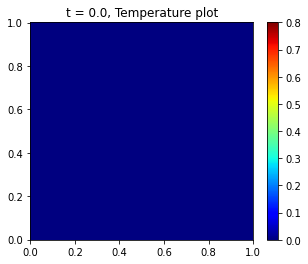

<Figure size 432x288 with 0 Axes>

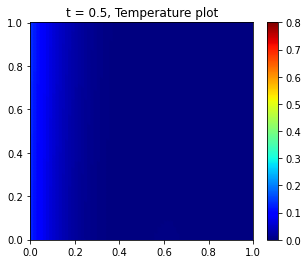

<Figure size 432x288 with 0 Axes>

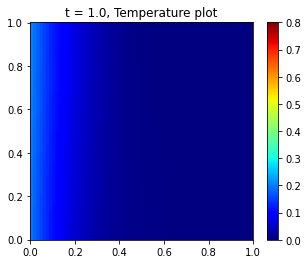

<Figure size 432x288 with 0 Axes>

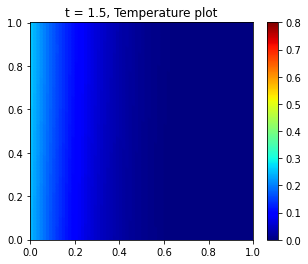

<Figure size 432x288 with 0 Axes>

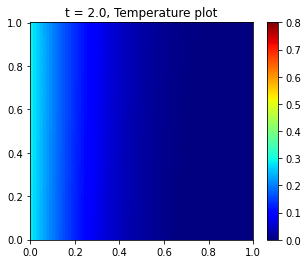

<Figure size 432x288 with 0 Axes>

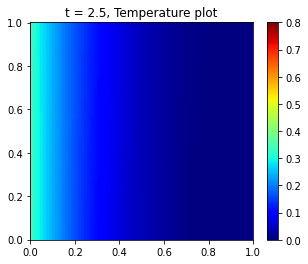

<Figure size 432x288 with 0 Axes>

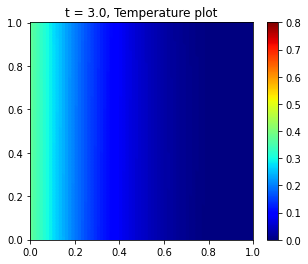

<Figure size 432x288 with 0 Axes>

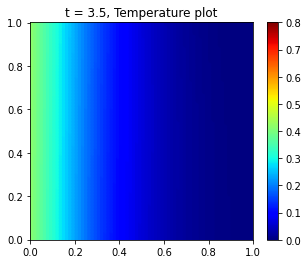

<Figure size 432x288 with 0 Axes>

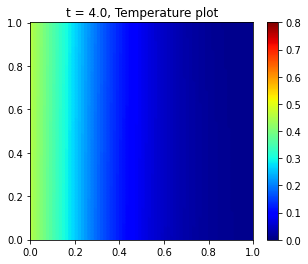

<Figure size 432x288 with 0 Axes>

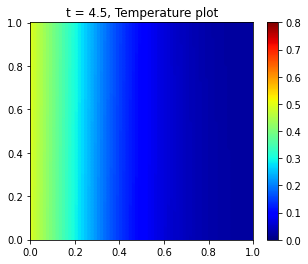

In [15]:
#### Plot temperature contours ##### 
del_t = (t_f - t_i)/(N_t - 1)
for k in range(N_t):

    if k%1 == 0 :
        plt.figure()
        plt.figure(figsize=(5,4))
        sc = plt.scatter(X_disp[k], Y_disp[k], c=T_disp[k], cmap=plt.cm.jet)
        plt.clim(0, 0.8)
        plt.xlim(x_l-0.001, x_r+0.001)
        plt.ylim(y_b-0.001, y_t+0.001)
        plt.colorbar(sc)
        plt.title('t = '+ str( round( k*del_t, 3) )+', Temperature plot')

plt.show()

In [16]:
max(T_disp[-1])

array([0.5041654], dtype=float32)

In [ ]:
#### Plot Liquid Fraction contours ##### 
for k in range(N_t):

    if k%1==0:
        plt.figure()
        plt.figure(figsize=(5,4))
        sc = plt.scatter(X_disp[k], Y_disp[k], c=F_disp[k], cmap=plt.cm.jet)
        plt.clim(0,1)
        plt.xlim(x_l-0.001, x_r+0.001)
        plt.ylim(y_b-0.001, y_t+0.001)
        plt.colorbar(sc)
        plt.title('t = '+ str( round( k*del_t, 3) )+', Liquid Fraction plot')

plt.show()

In [18]:
#### Save the weights ####
path = 'C:/UserS/USER/Desktop/Sanjeet MTP/t5_flux450_fac300_rbfnn_20neurons_2HL_1sideflux_fulldomain.pth'
save_model(model, path)

In [8]:
import openpyxl

#### contour generation for paper ####
x_l = 0
x_r = 1
N_x = 81
y_b = 0
y_t = 1
N_y = 81

X = np.linspace(x_l,x_r,N_x)
X_np = np.tile(X,N_y)
Y = np.linspace(y_b,y_t,N_y)
Y_np = np.repeat(Y,N_x)
X = np_to_torch(X_np)
Y = np_to_torch(Y_np)
X_np = X.detach().numpy()
Y_np = Y.detach().numpy()

model.train()  
path = 't5_flux450_fac600_rbfnn_20neurons_2HL_1sideflux_fulldomain.pth'
load_model(model, path)
workbook = openpyxl.Workbook()

for time in [1.6, 3.2, 4.8]:
    
    X_new = []
    Y_new = []
    T_new = []
    
    t = np.ones((N_x*N_y))*time
    t = np_to_torch(t)
    T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, m1, Ns1, m2, Ns2 = model(X, Y, t, start, 0, 0)
    T = T.detach().numpy()
    
    print(T.shape[0])
    for i in range(T.shape[0]):
        X_new.append(X_np[i])
        Y_new.append(Y_np[i])
        T_new.append(T[i])

    arr = np.concatenate((X_new, Y_new, T_new), 1)
    print(arr.shape)
    arr = arr.tolist()

    ### Save it in workbook ###
    sheet = workbook.create_sheet(title="t = "+str(time))
    sheet.append(['X', 'Y', 'T'])
    for row in arr:
        sheet.append(row)
        
# Save the workbook to the specified file
file_name = "PINN_1side_fulldomain.xlsx"
workbook.save(file_name)
print(f"Data saved to {file_name}")

6561
(6561, 3)
6561
(6561, 3)
6561
(6561, 3)
Data saved to PINN_1side_fulldomain.xlsx


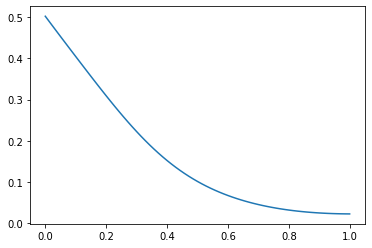

In [17]:
#### Plot graphs ####
x_T = np.linspace(x_l, 1, N_x)
# y_T = np.linspace(x_l, 0.3, N_x)
y_T = np.ones((N_x))*0.5
t_T = np.ones((N_x))*4.5

x_T = np_to_torch(x_T)
y_T = np_to_torch(y_T)
t_T = np_to_torch(t_T)

T, dTdx, dTdy, d2Tdx2, d2Tdy2, dTdt, m1, Ns1, m2, Ns2 = model( x_T, y_T, t_T, start, 0, 0)
X = x_T.detach().numpy()
X = X.squeeze(-1)
Y = y_T.detach().numpy()
Y = Y.squeeze(-1)
t = t_T.detach().numpy()
t = t.squeeze(-1)
T = T.detach().numpy()
T = T.squeeze(-1)

plt.plot(X, T)

In [ ]:
# df = pd.DataFrame(list(zip(X, T)), columns = ['x', 'Temperature'])
# df.to_excel("PINN_2sideflux_y0.2_1aside.xlsx")